# License Plate Recognition

In [38]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [39]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pixiedust
import cv2

## Generate training data

In [40]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps

In [321]:
PATH = 'data/lpr/'
#!wget -O data/lpr/sample.jpg http://www.esbjergkommune.dk/Files/Billeder/Borger/Vej%20og%20trafik/Offentlig%20vej/Villavej_418x235.jpg
sample = f'{PATH}sample.jpg'
image = Image.open(sample)

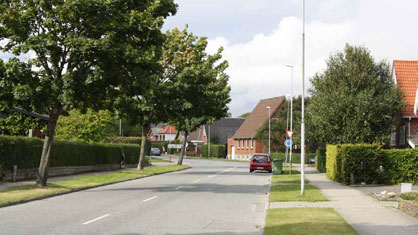

In [322]:
image

In [323]:
image.size

(418, 235)

### Generate license plate

In [324]:
def license_plate(image, license, width = 40):
    w = width
    h = (int)(w / 4)
    red_width = (int)(w / 100)
    font_size = (int)(w / 5)
    
    #font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-C.ttf', font_size)
    #font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf', font_size)
    #font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', font_size)
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', font_size)
    
    size = (w, h)
    plate = Image.new('RGB', size, "red")
    
    draw = ImageDraw.Draw(plate)
    draw.rectangle(((red_width, red_width),(w-red_width-1, h-red_width-1)), fill="white")
    (tw, th) = font.getsize(license)
    text_position = ((w-tw)/2, (h-th)/2-1)
    #draw.rectangle(text_position + (text_position[0]+tw,text_position[1]+th), fill="blue")
    draw.text(text_position, license, font=font, fill="black")
    #draw.line([(9,9), (9+tw,9+th)], width=1)
    
    box = (random.randint(0, image.size[0] - w), random.randint(0, image.size[1] - h))
    bbox = (box[0], box[1], box[0]+w, box[1]+h)
    image.paste(plate, box=box)
    
    
    return bbox, image

In [325]:
#%%pixie_debugger
bbox, sample = license_plate(image, 'UM 12 345', 50)
bbox

(323, 216, 373, 228)

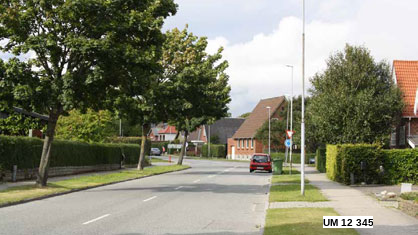

In [326]:
sample

## Split video to images

In [140]:
path_frames = f'{PATH}frames/'
try:
    if not os.path.exists(path_frames):
        os.makedirs(path_frames)
except OSError:
    print("Cannot create dir for frames")

In [10]:
def split_video_in_frames(video):
    capture = cv2.VideoCapture(video)
    ret = True
    currentFrame = 0
    while(ret):
        ret, frame = capture.read()
        if (ret):
            name = path_frames + str(currentFrame) + '.jpg'
            #print ('Creating ' + name)
            cv2.imwrite(name, frame)
            currentFrame += 1
    capture.release()
    cv2.destroyAllWindows()
    return currentFrame

In [12]:
video = f"{PATH}VID_20180902_181340.mp4"
frames_created = split_video_in_frames(video)
f'{frames_created} frames created.'

'7430 frames created.'

## Generate license plates

In [141]:
path_train = f'{PATH}train/'
try:
    if not os.path.exists(path_train):
        os.makedirs(path_train)
except OSError:
    print("Cannot create dir for training images")

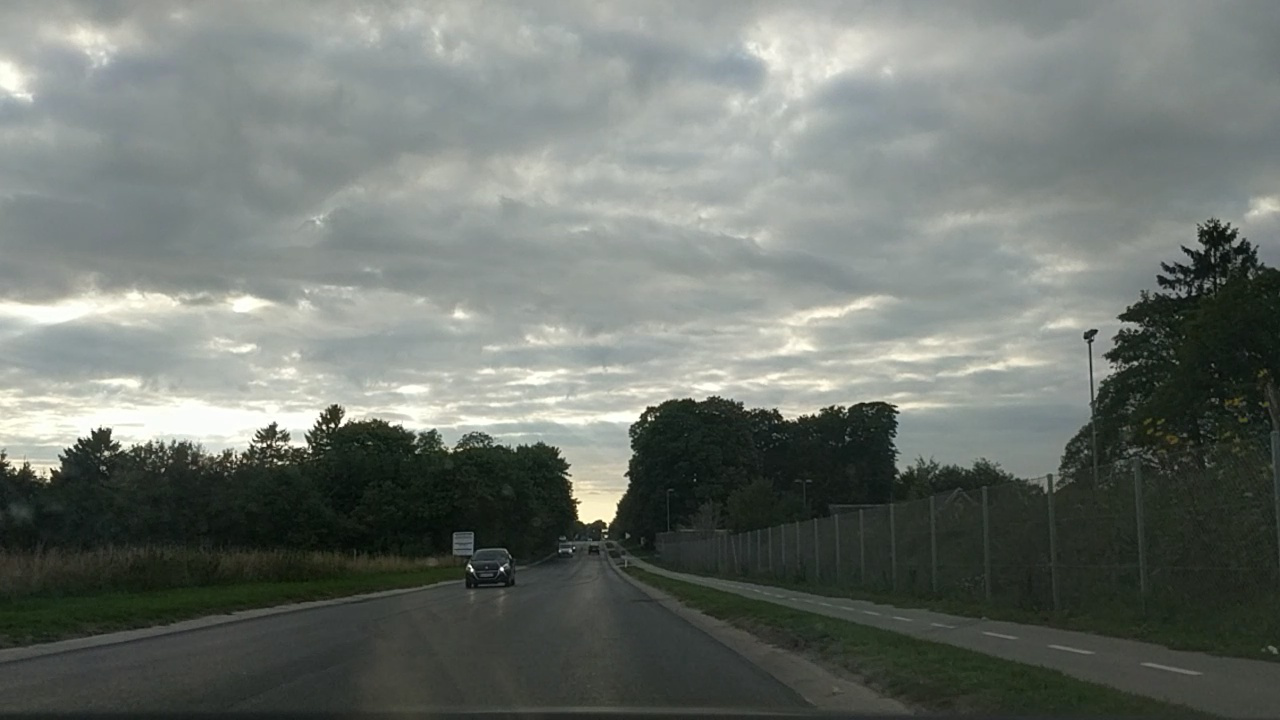

In [328]:
max = !ls data/lpr/frames | wc -l
max = int(max[0])
def random_image():
    filename = path_frames + str(random.randint(0, max)) + '.jpg'
    return Image.open(filename)
random_image()

In [329]:
def random_letter():
    return random.choice("ABCDEFGHIJKLMNOPQRSTUXYZ")

def random_number():
    return str(random.randint(10000, 99999))

def random_license():
    return random_letter() + random_letter() + " " + random_number()

random_license()

'PX 41078'

In [333]:
def create_train_images(n):
    images = []
    for i in range(0, n):
        license = random_license()
        file = path_train + license + ".jpg"
        bbox, image = license_plate(random_image(), license, width=random.randint(30, 60))
        image.save(file)
        images.append((bbox, file))
    return images
                            

In [334]:
train = create_train_images(500)
train

[((99, 65, 152, 78), 'data/lpr/train/OZ 28301.jpg'),
 ((805, 516, 855, 528), 'data/lpr/train/LU 27166.jpg'),
 ((1163, 38, 1200, 47), 'data/lpr/train/AK 50122.jpg'),
 ((658, 443, 705, 454), 'data/lpr/train/FU 93821.jpg'),
 ((782, 596, 823, 606), 'data/lpr/train/CN 24009.jpg'),
 ((190, 152, 220, 159), 'data/lpr/train/FA 74940.jpg'),
 ((1115, 534, 1148, 542), 'data/lpr/train/AG 71826.jpg'),
 ((638, 184, 668, 191), 'data/lpr/train/NR 24242.jpg'),
 ((0, 505, 52, 518), 'data/lpr/train/YT 77517.jpg'),
 ((951, 523, 993, 533), 'data/lpr/train/LF 28630.jpg'),
 ((34, 303, 68, 311), 'data/lpr/train/CB 47323.jpg'),
 ((695, 2, 728, 10), 'data/lpr/train/IO 37985.jpg'),
 ((758, 368, 788, 375), 'data/lpr/train/BL 53456.jpg'),
 ((385, 220, 442, 234), 'data/lpr/train/CQ 17863.jpg'),
 ((376, 62, 410, 70), 'data/lpr/train/LZ 24007.jpg'),
 ((431, 555, 487, 569), 'data/lpr/train/RF 23044.jpg'),
 ((296, 363, 329, 371), 'data/lpr/train/DL 10501.jpg'),
 ((512, 457, 562, 469), 'data/lpr/train/RN 27251.jpg'),
 ((

In [342]:
train[0][0]

(99, 65, 152, 78)

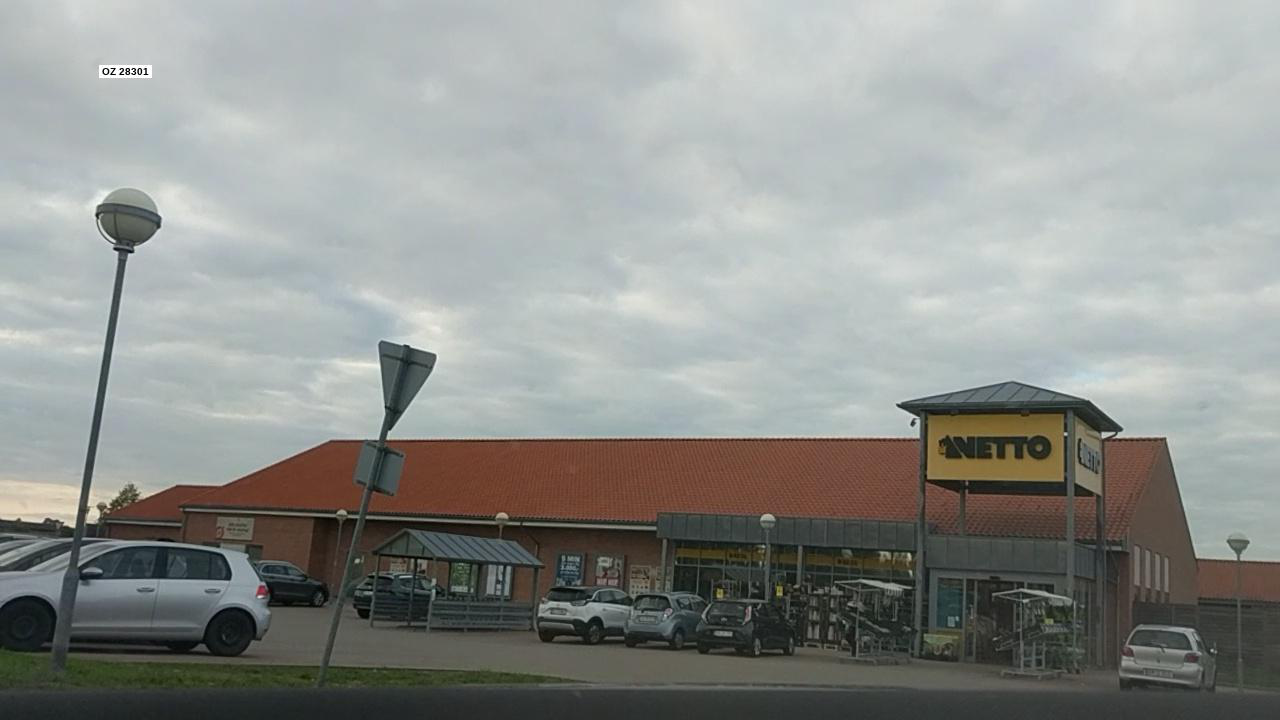

In [343]:
Image.open(train[0][1])